# Fridge Vision

### Colab Link:
https://colab.research.google.com/drive/19pA8NWQRZiGq8pt_Iiie1WtEVfCgW1Mm?usp=sharing

## 1. Data Collectiing, Loading, Preprocessing

## DataSet

Fridge food images, with labelled food type using colored boxes, which are used for training in YOLO model.







# MobileNet for Single Food Recognition and Classification

- Using MobileNet as a pretrained model for food and vegetable recognition
- Aiming for efficiency and lower computational requirement
- MobileNet's pretrained layers act as feature extractors, then fine-tune the model for food recognition and classification task



## 1. Data Preprocessing

### 1.1 Import libraries


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.models import mobilenet_v2
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
!unzip /content/new_dataset.zip -d /content

Archive:  /content/new_dataset.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/new_dataset.zip or
        /content/new_dataset.zip.zip, and cannot find /content/new_dataset.zip.ZIP, period.


In [3]:
!pip install roboflow supervision opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 16.4 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [4]:
import torch
from roboflow import Roboflow
import supervision as sv
import cv2
import os
from PIL import Image

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
!cp -r /content/drive/MyDrive/ColabNotebooks/aps360_dummyresult_11_26/results/predict/crops/dummy /content/testing

In [ ]:


rf = Roboflow(api_key="Hxf0mSTlVAZoc1jBBQJr")
project = rf.workspace("tiffanyzha").project("croppedsmallimage")
version = project.version(1)
dataset = version.download("yolov5")



# rf = Roboflow(api_key="ayL48plh8fqJBfMTdBUb")
# project = rf.workspace("steph-r3xmc").project("croppedimages-fwc1r")
# version = project.version(1)
# dataset = version.download("yolov5")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to CroppedSmallImage-1 in yolov5pytorch:: 100%|██████████| 37270/37270 [00:06<00:00, 5784.59it/s]


In [ ]:
%pwd

'/content'

In [ ]:
%mkdir croppedImages

In [ ]:
import os
import shutil

# Define the path to your original dataset
source_dataset_path = '/content/CroppedSmallImage-1'
destination_dataset_path = '/content/new_dataset'

# Mapping from class index to class name (you can modify this as per your dataset)
# class_names = [
#     'apple',
#     'asparagus',
#     'bacon',
#     'banana',
#     'basil',
#     'beans',
#     'beef',
#     'bitter gourd',
#     'blueberries',
#     'bok choy',
#     'bread',
#     'broccoli',
#     'butter',
#     'cabbage',
#     'carrot',
#     'cauliflower',
#     'cheese',
#     'chicken',
#     'chillies',
#     'coriander',
#     'corn',
#     'cream',
#     'cucumber',
#     'egg',
#     'fish',
#     'garlic',
#     'ginger',
#     'green beans',
#     'green pepper',
#     'ham',
#     'jam',
#     'juice',
#     'lemon',
#     'lettuce',
#     'lime',
#     'meat',
#     'milk',
#     'mushroom',
#     'olive',
#     'onion',
#     'orange',
#     'potato',
#     'pumpkin',
#     'red bell pepper',
#     'salami',
#     'sausage',
#     'shrimp',
#     'spinach',
#     'strawberry',
#     'sugar',
#     'sweet potato',
#     'tomato',
#     'watermelon',
#     'yellow bell pepper',
#     'yoghurt'
# ]

class_names = [
    "apple", "asparagus", "bacon", "banana", "basil", "beans", "beef", "bell pepper", "bitter gourd",
    "blueberries", "bok choy", "bread", "broccoli", "butter", "cabbage", "carrot", "cauliflower",
    "cheese", "chicken", "chillies", "chocolate", "coriander", "corn", "cream", "cucumber", "egg",
    "eggplant", "eggs", "fish", "flour", "garlic", "ginger", "green beans", "green chilies", "green pepper",
    "ham", "jam", "juice", "lemon", "lettuce", "lime", "meat", "milk", "mushroom", "olive", "onion",
    "orange", "parsley", "potato", "pumpkin", "red bell pepper", "salami", "sauce", "sausage", "shrimp",
    "spinach", "strawberry", "sugar", "sweet potato", "tomato", "watermelon", "yellow bell pepper", "yoghurt"
]


# Example

# Function to create the necessary directories if they don't exist
def create_class_folders(base_path):
    for class_name in class_names:
        class_folder = os.path.join(base_path, class_name)
        if not os.path.exists(class_folder):
            os.makedirs(class_folder)

# Function to move images to their respective class folders based on labels

def organize_images(src_images_folder, src_labels_folder, dst_folder):
    image_files = os.listdir(src_images_folder)

    for image_file in image_files:
        # Get the corresponding label file
        label_file = image_file.replace('.jpg', '.txt')
        label_path = os.path.join(src_labels_folder, label_file)

        # Read the label file (assuming there's only one line)
        with open(label_path, 'r') as f:
            line = f.readline().strip()  # Read the single line and strip any surrounding whitespaces

        # Parse the label (class_index, center_x, center_y, width, height)
        class_index = int(line.split()[0])

        # Determine the class name
        class_name = class_names[class_index]

        # Move the image to the corresponding class folder
        src_image_path = os.path.join(src_images_folder, image_file)
        dst_image_folder = os.path.join(dst_folder, class_name)

        # Ensure the destination class folder exists
        if not os.path.exists(dst_image_folder):
            os.makedirs(dst_image_folder)

        # Move the image
        dst_image_path = os.path.join(dst_image_folder, image_file)
        shutil.move(src_image_path, dst_image_path)
        print(f"Moved {image_file} to {dst_image_folder}")

# Organize the train, valid, and test datasets
for split in ['train', 'valid', 'test']:
    # Define the source and destination paths
    src_images_folder = os.path.join(source_dataset_path, split, 'images')
    src_labels_folder = os.path.join(source_dataset_path, split, 'labels')
    dst_folder = os.path.join(destination_dataset_path, split)

    # Create class folders for the split
    create_class_folders(dst_folder)

    # Organize the images and labels into their respective class folders
    organize_images(src_images_folder, src_labels_folder, dst_folder)

print("Dataset organization complete!")


Streaming output truncated to the last 5000 lines.
Moved IMG_3271_jpg.rf.c14f9df8149e37c3ea356975420189ce.jpg to /content/new_dataset/valid/cucumber
Moved 20230924_090243_jpg.rf.ad0f391af49c08f76d4f047e9106e349.jpg to /content/new_dataset/valid/watermelon
Moved 20231121_201612_jpg.rf.4902f4d75e3fed264492e7ee4551662a.jpg to /content/new_dataset/valid/carrot
Moved WechatIMG11_jpg.rf.62f36eb73a7fbfd14e81d13f14d159d1.jpg to /content/new_dataset/valid/shrimp
Moved IMG_0726_JPEG_jpg.rf.4696b7daf49347226bc6f2c969fc1bb3.jpg to /content/new_dataset/valid/cabbage
Moved IMG_3201_jpg.rf.f8d2ba627f58fdaef53b0287a411a822.jpg to /content/new_dataset/valid/onion
Moved 20231009_090811_jpg.rf.0c5b3075f7bf5926739eebe844602f31.jpg to /content/new_dataset/valid/garlic
Moved IMG_2875_jpg.rf.37d0432e771b0b634e58b01a8a877d2d.jpg to /content/new_dataset/valid/tomato
Moved IMG_2821_jpg.rf.8cd03c2bbc3b6993b51f3643c6a539f4.jpg to /content/new_dataset/valid/carrot
Moved IMG_2721_JPEG_jpg.rf.ac0dc9bfeda2a8b2e533588

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!cp -r /content/new_dataset /content/drive/MyDrive/ColabNotebooks/aps360_newcroppedImages

In [ ]:
!cp -r /content/drive/MyDrive/ColabNotebooks/aps360_newcroppedImages /content/new_dataset

^C


In [ ]:
from google.colab import files
files.upload()  # This will prompt you to upload the kaggle.json file


MessageError: RangeError: Maximum call stack size exceeded.

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d kritikseth/fruit-and-vegetable-image-recognition


Dataset URL: https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition
License(s): CC0-1.0
100% 1.98G/1.98G [01:29<00:00, 23.8MB/s]
100% 1.98G/1.98G [01:29<00:00, 23.7MB/s]


In [ ]:
!unzip fruit-and-vegetable-image-recognition.zip -d fruit_and_vegetable_data

Archive:  fruit-and-vegetable-image-recognition.zip
  inflating: fruit_and_vegetable_data/test/apple/Image_1.jpg  
  inflating: fruit_and_vegetable_data/test/apple/Image_10.jpg  
  inflating: fruit_and_vegetable_data/test/apple/Image_2.jpg  
  inflating: fruit_and_vegetable_data/test/apple/Image_3.jpg  
  inflating: fruit_and_vegetable_data/test/apple/Image_4.jpg  
  inflating: fruit_and_vegetable_data/test/apple/Image_5.jpg  
  inflating: fruit_and_vegetable_data/test/apple/Image_6.JPG  
  inflating: fruit_and_vegetable_data/test/apple/Image_7.jpg  
  inflating: fruit_and_vegetable_data/test/apple/Image_8.jpg  
  inflating: fruit_and_vegetable_data/test/apple/Image_9.jpg  
  inflating: fruit_and_vegetable_data/test/banana/Image_1.jpg  
  inflating: fruit_and_vegetable_data/test/banana/Image_10.jpg  
  inflating: fruit_and_vegetable_data/test/banana/Image_2.jpg  
  inflating: fruit_and_vegetable_data/test/banana/Image_3.jpg  
  inflating: fruit_and_vegetable_data/test/banana/Image_4.jp

In [ ]:
import os

# Load the dataset using pytorch

# Define your data directory
#data_dir = 'fruit_and_vegetable_data'
data_dir = '/content/new_dataset'
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# train_classes = []
# val_classes = []

# # Remove empty class folders
# train_dir = os.path.join(data_dir, 'train')
# for class_folder in os.listdir(train_dir):
#     class_path = os.path.join(train_dir, class_folder)
#     if os.path.isdir(class_path) and not any(os.scandir(class_path)):
#         print(f"Skipping empty class folder: {class_folder}")
#         os.rmdir(class_path)  # Optionally remove the empty folder
#     #train_classes.append(class_folder)

# val_dir = os.path.join(data_dir, 'valid')
# for class_folder in os.listdir(val_dir):
#     class_path = os.path.join(val_dir, class_folder)
#     if os.path.isdir(class_path) and not any(os.scandir(class_path)):
#         print(f"Skipping empty class folder: {class_folder}")
#         os.rmdir(class_path)  # Optionally remove the empty folder
#     #val_classes.append(class_folder)


# Load the training dataset
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Load the validation dataset
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'valid'), transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

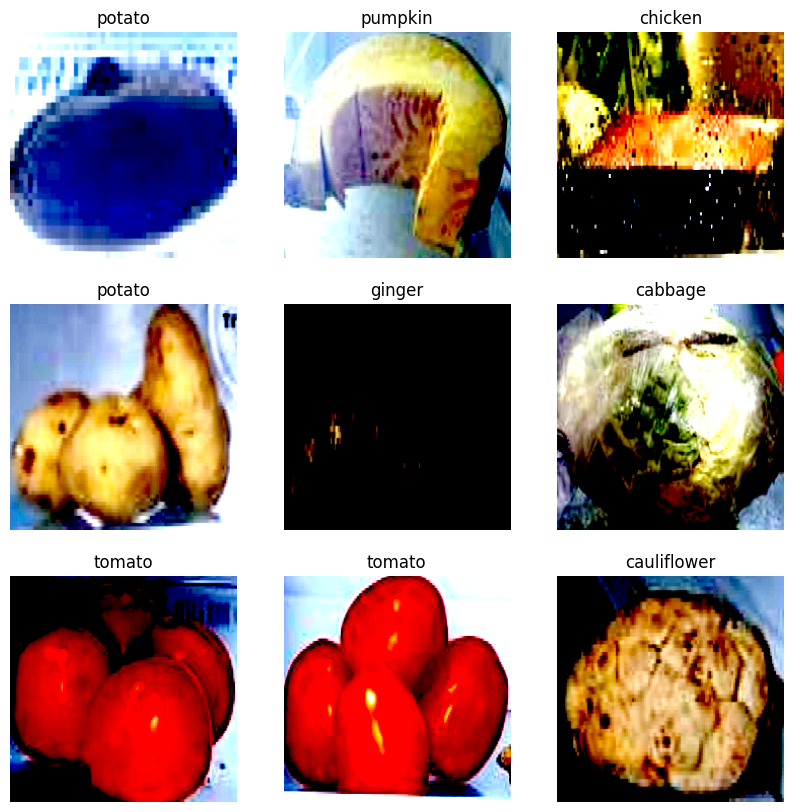

In [ ]:
# import numpy as np
# food_class = ["apple", "banana", "beetroot", "bell pepper", "cabbage", "capsicum", "carrot", "cauliflower", "chilli pepper", "corn", "cucumber", "eggplant", "garlic", "ginger", "grapes", "jalepeno", "kiwi", "lemon", "lettuce", "mango", "onion", "orange", "paprika", "pear", "peas", "pineapple", "pomegranate", "potato", "raddish", "soy beans", "spinach", "sweetcorn", "sweetpotato", "tomato", "turnip", "watermelon"]

# def display_images(dataset, num_images=9):
#     plt.figure(figsize=(10, 10))
#     for i, (images, labels) in enumerate(dataset):  # Iterate through the DataLoader
#         if i >= 1:  # Only display one batch
#             break
#         for j in range(num_images):
#             ax = plt.subplot(3, 3, j + 1)
#             image = images[j].numpy().transpose((1, 2, 0))  # Convert to HWC format
#             image = np.clip(image, 0, 1)  # Ensure pixel values are between 0 and 1
#             plt.imshow(image)  # Display image
#             plt.title(food_class[int(labels[j].item())])  # Display label
#             plt.axis("off")

# # Display images from the training dataset
# display_images(train_loader)


import numpy as np
import matplotlib.pyplot as plt

# food_class = [
#     "apple", "banana", "beetroot", "bell pepper", "cabbage", "capsicum",
#     "carrot", "cauliflower", "chilli pepper", "corn", "cucumber", "eggplant",
#     "garlic", "ginger", "grapes", "jalepeno", "kiwi", "lemon", "lettuce",
#     "mango", "onion", "orange", "paprika", "pear", "peas", "pineapple",
#     "pomegranate", "potato", "raddish", "soy beans", "spinach", "sweetcorn",
#     "sweet potato", "tomato", "turnip", "watermelon"
# ]
food_class = class_names


def display_images(dataset, num_images=9):
    plt.figure(figsize=(10, 10))
    for i, (images, labels) in enumerate(dataset):  # Iterate through the DataLoader
        if i >= 1:  # Only display one batch
            break
        for j in range(num_images):
            ax = plt.subplot(3, 3, j + 1)
            image = images[j].numpy().transpose((1, 2, 0))  # Convert to HWC format

            # Adjust brightness by normalizing pixel values
            image = np.clip(image, 0, 1)  # Ensure pixel values are between 0 and 1
            image = image ** 0.6  # Adjust brightness (you can change the exponent)

            plt.imshow(image)  # Display image
            plt.title(food_class[int(labels[j].item())])  # Display label
            #plt.title(labels[j].item())
            plt.axis("off")

# Display images from the training dataset
display_images(train_loader)


## 2. Load the MobileNet as pretrained model

In [12]:
# Load MobileNet with pretrained weights
mobilenet = models.mobilenet_v2(pretrained=True)

# Freeze parameters of the pretrained model
for param in mobilenet.parameters():
    param.requires_grad = False

# Modify the classifier layer to match the number of classes in the food dataset
#num_classes = len(train_dataset.classes)
num_classes = 55
mobilenet.classifier[1] = nn.Linear(mobilenet.last_channel, num_classes)

## 2.1 Define Loss function and Optimizer

In [7]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mobilenet.classifier[1].parameters(), lr=0.001)


## 2.2 Train the model


Epoch [1/10], Loss: 1.1754
Validation Accuracy: 82.36%
Epoch [2/10], Loss: 0.6071
Validation Accuracy: 84.54%
Epoch [3/10], Loss: 0.4860
Validation Accuracy: 85.82%
Epoch [4/10], Loss: 0.4342
Validation Accuracy: 87.21%
Epoch [5/10], Loss: 0.3930
Validation Accuracy: 87.52%
Epoch [6/10], Loss: 0.3574
Validation Accuracy: 87.11%
Epoch [7/10], Loss: 0.3467
Validation Accuracy: 87.19%
Epoch [8/10], Loss: 0.3329
Validation Accuracy: 88.21%
Epoch [9/10], Loss: 0.3270
Validation Accuracy: 88.29%
Epoch [10/10], Loss: 0.3202
Validation Accuracy: 87.86%


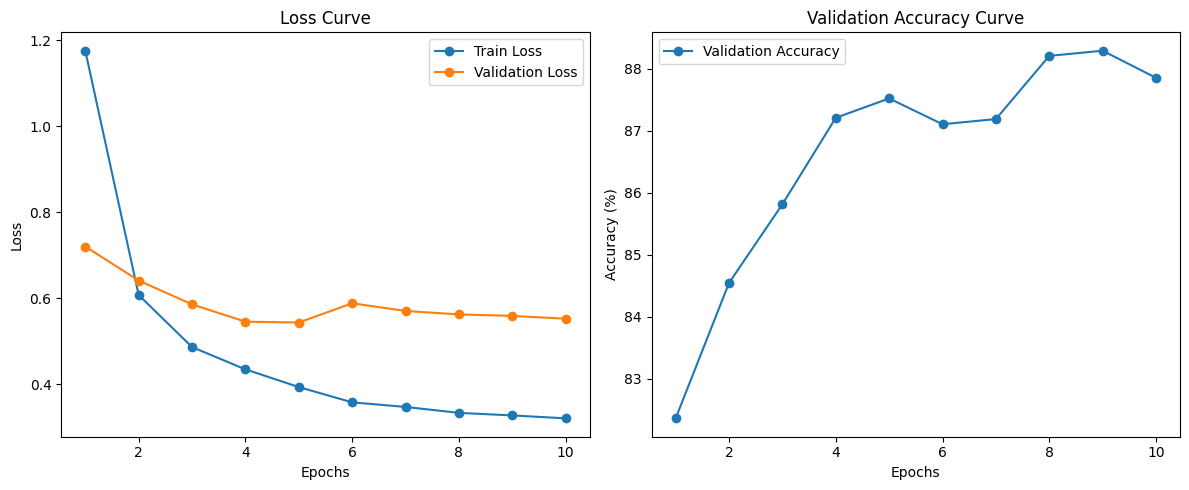

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt

# Forward Propogation

num_epochs = 10  # Set to a higher number for a better-trained model
mobilenet = mobilenet.to('cuda')

train_losses = []
val_losses = []
val_accuracies = []


for epoch in range(num_epochs):
    mobilenet.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to('cuda'), labels.to('cuda')

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = mobilenet(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()


    train_losses.append(running_loss / len(train_loader))
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {train_losses[-1]:.4f}")
    # print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

    # Validation step (optional but recommended)
    mobilenet.eval()
    val_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to('cuda'), labels.to('cuda')
            outputs = mobilenet(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f'Validation Accuracy: {val_accuracy:.2f}%')

# Plotting the learning curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='o')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', marker='o')
plt.title('Validation Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()



## 2.3 Save the trained model

In [ ]:
 # Save the trained model
torch.save(mobilenet.state_dict(), 'mobilenet_food_recognition.pth')


## 2.4 Testing and Prediction

63
/content/testing/dummy/74.jpg


/content/testing/dummy/73.jpg
/content/testing/dummy/72.jpg
/content/testing/dummy/7.jpg


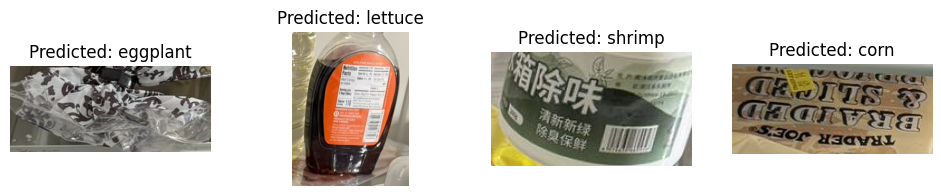

In [13]:
class_names = [
    "apple", "asparagus", "bacon", "banana", "basil", "beans", "beef", "bell pepper", "bitter gourd",
    "blueberries", "bok choy", "bread", "broccoli", "butter", "cabbage", "carrot", "cauliflower",
    "cheese", "chicken", "chillies", "chocolate", "coriander", "corn", "cream", "cucumber", "egg",
    "eggplant", "eggs", "fish", "flour", "garlic", "ginger", "green beans", "green chilies", "green pepper",
    "ham", "jam", "juice", "lemon", "lettuce", "lime", "meat", "milk", "mushroom", "olive", "onion",
    "orange", "parsley", "potato", "pumpkin", "red bell pepper", "salami", "sauce", "sausage", "shrimp",
    "spinach", "strawberry", "sugar", "sweet potato", "tomato", "watermelon", "yellow bell pepper", "yoghurt"
]
food_class = class_names
print(len(food_class))
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model and transfer it to the appropriate device
mobilenet.load_state_dict(torch.load('/content/mobilenet_food_recognition.pth', map_location=device))
mobilenet.to(device)  # Move model to the chosen device
mobilenet.eval()

from PIL import Image
import torchvision.transforms as transforms
import os
import matplotlib.pyplot as plt


preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


test_dir = '/content/testing/dummy'
#test_dir = '/content/new_dataset/test'

# # Initialize metrics
# correct = 0
# total = 0
# total_loss = 0
criterion = torch.nn.CrossEntropyLoss()

# Prepare for plotting images
plot_images = []
# actual_labels = []
predicted_labels = []


for root, dirs, files in os.walk('/content/testing'):
    if '.ipynb_checkpoints' in dirs:
        dirs.remove('.ipynb_checkpoints')  # Skip the checkpoint directory

# Make predictions on test images
for img_file in os.listdir(test_dir):
    # category_path = os.path.join(test_dir, category)
    # if os.path.isdir(category_path):
        # for img_file in os.listdir(category_path):
            img_path = os.path.join(test_dir, img_file)
            print(img_path)
            image = Image.open(img_path)
            # Convert image to RGB if it has an alpha channel
            if image.mode != 'RGB':
                image = image.convert('RGB')

            img_tensor = preprocess(image).unsqueeze(0).to(device)
            # true_label = food_class.index(category)


            with torch.no_grad():
                output = mobilenet(img_tensor)
                predicted_index = output.argmax(dim=1).item()
                predicted_label = food_class[predicted_index]

                # Calculate loss
                # loss = criterion(output, torch.tensor([true_label]).to(device))
                # total_loss += loss.item()

            # Update metrics
            # correct += (predicted_index == true_label)
            # total += 1

            # Store for plotting
            plot_images.append(image)
            # actual_labels.append(category)
            predicted_labels.append(predicted_label)

            # plt.imshow(image)
            # plt.title(f'Actual: {category}, Predicted: {predicted_label}')
            # plt.axis('off')
            # plt.show()

# Calculate accuracy and average loss
# accuracy = correct / total if total > 0 else 0
# average_loss = total_loss / total if total > 0 else 0
# error_rate = 1 - accuracy

# Print the metrics
# print(f'Accuracy: {accuracy:.4f}')
# print(f'Average Loss: {average_loss:.4f}')
# print(f'Error Rate: {error_rate:.4f}')

# Plotting images with actual and predicted labels
num_images = len(plot_images)
plt.figure(figsize=(15, num_images // 5 + 2))  # Adjust the figure height based on number of images
for i in range(num_images):
    plt.subplot(num_images // 5 + 1, 5, i + 1)  # Create a grid of subplots
    plt.imshow(plot_images[i])
    plt.title(f'Predicted: {predicted_labels[i]}')
    plt.axis('off')

# plt.tight_layout()
plt.show()


In [ ]:
for img_file in os.listdir(category_path):
            img_path = os.path.join(category_path, img_file)
            image = Image.open(img_path)
            # Convert image to RGB if it has an alpha channel
            if image.mode != 'RGB':
                image = image.convert('RGB')

            img_tensor = preprocess(image).unsqueeze(0).to(device)
            true_label = food_class.index(category)


            with torch.no_grad():
                output = mobilenet(img_tensor)
                predicted_index = output.argmax(dim=1).item()
                predicted_label = food_class[predicted_index]

                # Calculate loss
                loss = criterion(output, torch.tensor([true_label]).to(device))
                total_loss += loss.item()

            # Update metrics
            correct += (predicted_index == true_label)
            total += 1

            # Store for plotting
            plot_images.append(image)
            actual_labels.append(category)
            predicted_labels.append(predicted_label)

            # plt.imshow(image)
            # plt.title(f'Actual: {category}, Predicted: {predicted_label}')
            # plt.axis('off')
            # plt.show()

# Calculate accuracy and average loss
accuracy = correct / total if total > 0 else 0
average_loss = total_loss / total if total > 0 else 0
error_rate = 1 - accuracy

# Print the metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Average Loss: {average_loss:.4f}')
print(f'Error Rate: {error_rate:.4f}')

# Plotting images with actual and predicted labels
num_images = len(plot_images)
plt.figure(figsize=(15, num_images // 5 + 2))  # Adjust the figure height based on number of images
for i in range(num_images):
    plt.subplot(num_images // 5 + 1, 5, i + 1)  # Create a grid of subplots
    plt.imshow(plot_images[i])
    plt.title(f'Actual: {actual_labels[i]}\nPredicted: {predicted_labels[i]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
image = Image.open("/content/BrightHomeFridge3.jpg")
# Convert image to RGB if it has an alpha channel
if image.mode != 'RGB':
  image = image.convert('RGB')

img_tensor = preprocess(image).unsqueeze(0).to(device)
true_label = food_class.index(category)


with torch.no_grad():
    output = mobilenet(img_tensor)
    predicted_index = output.argmax(dim=1).item()
    predicted_label = food_class[predicted_index]
    print(predicted_label)


tomato
